HDF5 版の XGBoost

In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 入力ファイルの皆さん
TRAINS = [
    "../hdf/train_categorical.hdf",
    "../hdf/train_numeric.hdf",
#     "../hdf/train_date_L0_normalized.hdf",
    "../hdf/train_date_L1_normalized.hdf",
    "../hdf/train_date_L2_normalized.hdf",
    "../hdf/train_date_L3_normalized.hdf",
    "../hdf/train_date_min_max.hdf",
    "../hdf/train_date_L0_min_max.hdf",
    "../hdf/train_date_L1_min_max.hdf",
    "../hdf/train_date_L2_min_max.hdf",
    "../hdf/train_date_L3_min_max.hdf",
    "../hdf/train_categorical_L3_S32_F3854_decomposite.hdf",
    "../hdf/train_numeric_L1_S24_F1844_extract.hdf",
    "../hdf/train_numeric_L1_S24_F1723_-0.12.hdf",
    "../hdf/train_numeric_L1_S24_F1723_extract.hdf",
    "../hdf/train_S24_C_md5.hdf"
]
TESTS = []
for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
RESPONSE = "../hdf/train_response.hdf"

In [3]:
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
columns = X.columns
md5_sum_S24_C_md5 = X.loc[[137]]["S24_C_md5"].values[0]
X = X[X["S24_C_md5"] == md5_sum_S24_C_md5]
indices = X.index
y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
X = X.values

CPU times: user 1min 37s, sys: 652 ms, total: 1min 37s
Wall time: 6.77 s


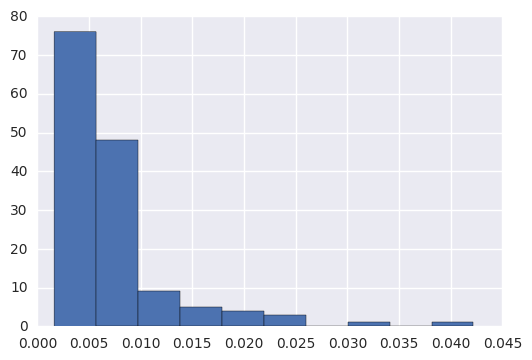

In [4]:
%%time
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)
plt.hist(clf.feature_importances_[clf.feature_importances_>0])

In [5]:
important_indices = np.where(clf.feature_importances_>0.001)[0]
important_columns = [columns[i] for i in important_indices]
important_columns

['L3_S32_F3854',
 'L1_S24_F1514',
 'L1_S24_F1516',
 'L1_S24_F1518',
 'L1_S24_F1520',
 'L1_S24_F1544',
 'L1_S24_F1565',
 'L1_S24_F1571',
 'L1_S24_F1575',
 'L1_S24_F1578',
 'L1_S24_F1581',
 'L1_S24_F1594',
 'L1_S24_F1599',
 'L1_S24_F1604',
 'L1_S24_F1627',
 'L1_S24_F1632',
 'L1_S24_F1637',
 'L1_S24_F1647',
 'L1_S24_F1652',
 'L1_S24_F1657',
 'L1_S24_F1662',
 'L1_S24_F1667',
 'L1_S24_F1763',
 'L1_S24_F1773',
 'L1_S24_F1778',
 'L1_S24_F1788',
 'L1_S24_F1798',
 'L1_S24_F1803',
 'L1_S24_F1808',
 'L1_S24_F1810',
 'L1_S24_F1812',
 'L1_S24_F1814',
 'L1_S24_F1816',
 'L1_S24_F1820',
 'L1_S24_F1824',
 'L1_S24_F1829',
 'L1_S24_F1831',
 'L1_S24_F1836',
 'L1_S24_F1842',
 'L1_S24_F1844',
 'L1_S24_F1846',
 'L1_S24_F1850',
 'L2_S26_F3036',
 'L2_S26_F3040',
 'L2_S26_F3047',
 'L2_S26_F3051',
 'L2_S26_F3055',
 'L2_S26_F3062',
 'L2_S26_F3069',
 'L2_S26_F3073',
 'L2_S26_F3077',
 'L2_S26_F3106',
 'L2_S26_F3113',
 'L2_S26_F3117',
 'L2_S26_F3121',
 'L2_S27_F3129',
 'L2_S27_F3133',
 'L2_S27_F3140',
 'L2_S27_F3144

In [6]:
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
y = pd.read_hdf(RESPONSE)

In [7]:
X = X.loc[:, important_columns]
X = X.loc[indices]
y = y.loc[X.index].values.ravel()
X = X.values

In [8]:
%%time
# 予測して Cross Validation
clf = XGBClassifier(max_depth=6, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.774
fold 1, ROC AUC: 0.764
fold 2, ROC AUC: 0.791
0.776117901878
CPU times: user 3min 3s, sys: 0 ns, total: 3min 3s
Wall time: 11.8 s


0.440624935988
CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.15 s


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


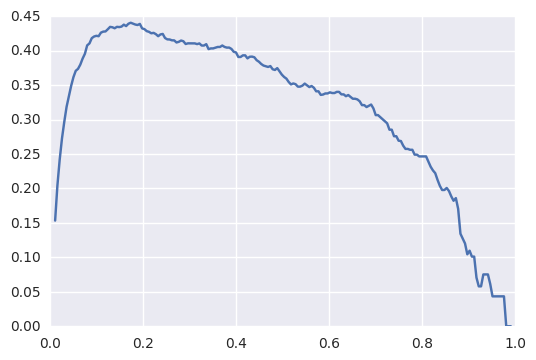

In [9]:
%%time
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [10]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_hdf(RESPONSE).loc[indices]
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,123,59061
1.0,176,349


提出用データを生成する

In [12]:
indices = pd.read_hdf("../hdf/test_S24_C_md5.hdf")
indices = indices["S24_C_md5"]
indices = indices[indices == md5_sum_S24_C_md5].index

In [22]:
indices = pd.read_hdf("../hdf/test_S24_C_md5.hdf")
indices = indices["S24_C_md5"]
indices = indices[indices != md5_sum_S24_C_md5].index
sub2 = sub

In [23]:
%%time
# テストデータ読み込み
X = pd.concat((pd.read_hdf(filename).loc[indices] for filename in TESTS), axis=1)

CPU times: user 37.8 s, sys: 21.7 s, total: 59.5 s
Wall time: 1min 5s


In [24]:
remove_columns = [c for c in X.columns if c not in important_columns]
X.drop(remove_columns, axis=1, inplace=True)

MemoryError: 

In [ ]:
X = X.values
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

In [ ]:
# 提出データを生成
sub = pd.DataFrame(index=indices.astype(np.int32), columns=[])
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")